# A look at predicting expected performance from training data
I am a middle-distance runner that has about a year of medium-quality training data. Here I will see if I can predict my expected performance based on previous training data. Even though machine learning is massive overkill for such a small sample size, and the data set is far from large enough to get a real effect from machine learning, I'm still hoping that machine learning will discover some patterns in the data. I'm not hoping to get any data for me to use from this as the data is far from good enough. This is more of a test as I am experimenting with the development of a new training diary that could get a lot better use of the following analysis.

### A short comment on the data
The value that I want to predict is my expected performance as an integer from 1 to 9. In my training diary, the expected performance is a subjective measure that I fill in for every workout, as mentioned, as an integer from 1 to 9. The training data is downloaded from the norwegian Olympiatoppens official training diary. I have chosen a few parameters from this that I am using for this analysis. These parameters are perceived exertion (subjective on a scale from 1 to 9), total km run, minutes in each of the 8 official intensity zones from OLT, and minutes trained strength.

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
import json

In [2]:
from organizeData import dataAsNumpyArraybyDayMaxForm, formAsFunctionOfPreviousTraining, removeZeroForm
from visualization import showGraphWithDataPoints
from machineLearning import runModel
from comparisons import formAsFunctionOfKMRanDayBefore, formAsFunctionOfTotalExertionDayBefore

In the next section I import my data from the file and organize it in a expected performance that is usable for the analysis that is to follow. If you are interested in the different functions used, you can take a look in the source files.

dataArray is an array that has all the data combined for each day. The expected performance of the i-th day can be found in dataArray[i, 0], and the rest of the parameters is in dataArray[i, n].

In [3]:
file = open("directionToFile.json")

dataDict = json.loads(file.read())

data = dataDict["user-cells"]
dataArray = dataAsNumpyArraybyDayMaxForm(data)

Next, I do some simple manipulations to see if I can spot some trends or find some weaknesses in my data. To do this I simply plot the expected performance as a function of percieved exertion from the day before, and the same for total ran km from the day before.

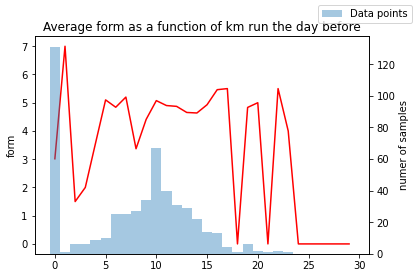

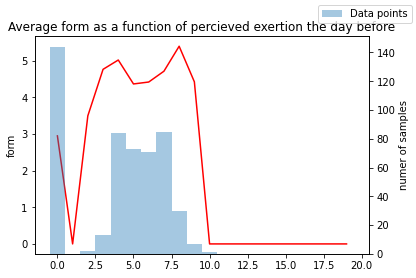

In [4]:
dataArray = dataAsNumpyArraybyDayMaxForm(data)

formAsFuncOfKmPrevDay, dataPointsKm = formAsFunctionOfKMRanDayBefore(dataArray)
formAsFuncOfExertionPrevDay, dataPointsExertion = formAsFunctionOfTotalExertionDayBefore(dataArray)

showGraphWithDataPoints(formAsFuncOfKmPrevDay, dataPointsKm, title="Average expected performance as a function of km run the day before")
showGraphWithDataPoints(formAsFuncOfExertionPrevDay, dataPointsExertion, title="Average expected performance as a function of percieved exertion the day before")


As we can see from the above plots, the 0 is dominating the samples i both cases. This can be a problem for the macine learning and I will soon look at how I can fix this.

In the next section I will do a simple algorithm based on a decision tree. In this example, I simply match up the expected performance of a day with the training data from the day before.

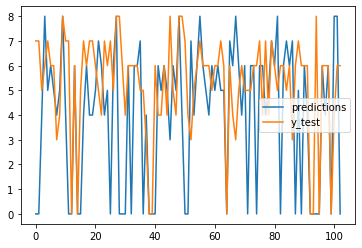

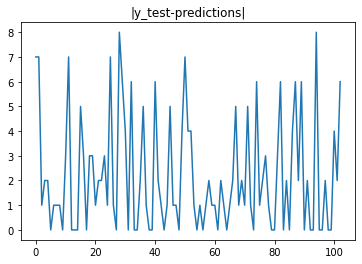

Score : 0.2912621359223301
Average error : 2.1844660194174756
Size of test-data : 103
Close hits (error<=1): 54
Big misses (error>=3): 33
Medium errors (2<=error<=3): 16


In [5]:
testData = np.copy(dataArray[1:])
testData[:, 0] = dataArray[1:, 0]
testData[:, 1:] = dataArray[:-1, 1:]
runModel(dataArray, mod=DecisionTreeClassifier)

As we can see, the fit is not terrible, but in some cases it misses terribly. As you can see from the plot, some of the data are zero. This is from the result that the days that I do not train, the expected performance is noted as 0. I remove these points and repeat the analysis.

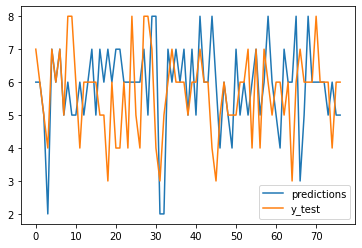

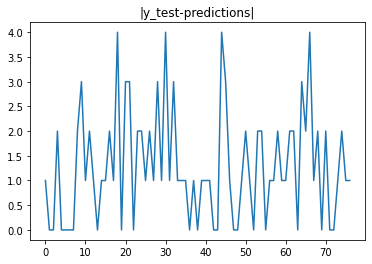

Score : 0.2727272727272727
Average error : 1.2857142857142858
Size of test-data : 77
Close hits (error<=1): 49
Big misses (error>=3): 11
Medium errors (2<=error<=3): 17


In [6]:
cleanedTestData = removeZeroForm(testData)
runModel(cleanedTestData, mod=DecisionTreeClassifier)

In the following lines I repeat the process but where I look at training done over the last two weeks in some sense.

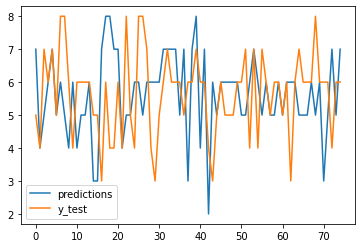

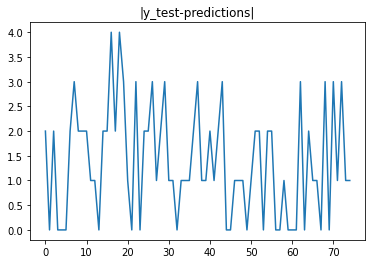

Score : 0.26666666666666666
Average error : 1.3733333333333333
Size of test-data : 75
Close hits (error<=1): 42
Big misses (error>=3): 13
Medium errors (2<=error<=3): 20


In [7]:
formAsPrevTraining = formAsFunctionOfPreviousTraining(dataArray)
cleanedFormAsPrevTraining = removeZeroForm(formAsPrevTraining)

runModel(cleanedFormAsPrevTraining, mod=DecisionTreeClassifier)

As I am not yet satisfied with my results I try Linear regression. But as you can see from the following plot, this method gives a very conservative graph that just sits in the middle.

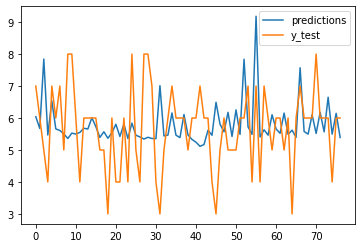

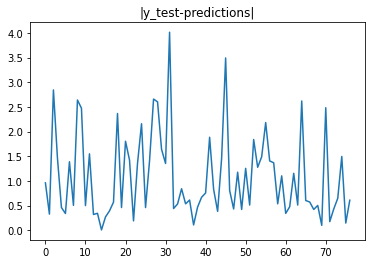

Score : -0.23976636500221815
Average error : 1.083133541623659
Size of test-data : 77
Close hits (error<=1): 44
Big misses (error>=3): 2
Medium errors (2<=error<=3): 10


In [70]:

cleanedDataArray = removeZeroForm(dataArray)

runModel(cleanedDataArray, mod=LinearRegression)

From the previous analysis, it is obvious that this is far to little data, and the best results have come from simply looking at the training from the previous day. As I train, continuity is one of the most important factors of success. Putting many good workouts together is more important than a few great workouts. Because of this, I am interested in if I can predict when I will have a bad day. This may help me take it easy before I have to and give a better total training load.

In the following cell I weigh the training-set as heavier if I have a bad day to better find when I will have a bad day.

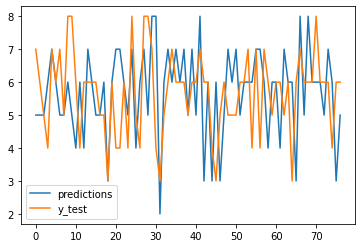

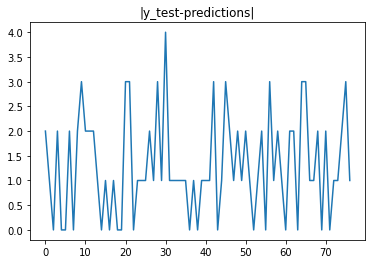

Score : 0.23376623376623376
Average error : 1.2987012987012987
Size of test-data : 77
Close hits (error<=1): 48
Big misses (error>=3): 11
Medium errors (2<=error<=3): 18


In [72]:
cleanedTestData = removeZeroForm(testData)
weight = np.ones(len(cleanedTestData))*10-cleanedTestData[:,0]

runModel(cleanedTestData, mod=DecisionTreeClassifier, weight=weight, testProportion=0.2)

As this model finds somewhat the velues below 4, I am interested to see what the computer looks for to predict a day with bad form:

In [76]:
model = DecisionTreeClassifier()
model.fit(cleanedTestData[:, 1:], cleanedTestData[:, 0], sample_weight=weight)
model.feature_importances_

array([0.12827004, 0.43788379, 0.14201129, 0.07043127, 0.0375443 ,
       0.03613883, 0.00846506, 0.02702577, 0.0151311 , 0.        ,
       0.09709856])

From the data above, we can see that the most important feature is the second feature. This is the amount of kms run the day prior. This is not very surprising as this gives a good indication on the training load. A day of a lot of kms will be hard and are often followed by a bad day. A day with medium amounts of kms will often be a good sign as I am in normal training, but will have energy left for the next day.

## Conclusion
As there are many factors that I d not have in this current dataset, such as sleep, time of workout etc. the analysis is never expected to be very accurate. The subjective score of expected performance that usually is around 5 is also not a good measure in the first place. But despite all this, I believe the data managed to pick up some trends, and I believe that an analysis of this expected performance may be usable for a future, better quality dataset.